### Exercise 4

#### Task 1

**Copy the ‘ARIMA_example.py’ code, tidy it up (remove unnecessary parts) and modify it to analyze stock exchange data. For example, go to www.marketwatch.com , seek some company using magnifying glass, click stock value and then ‘Historical Quotes’. You can download .csv data from there, take 3 months (daily values) at minimum.**

nvda_data.csv contains last 3kk daily values from 18.9. - 18.12.2024. Downloaded from Investing.com. 

Import libraries

In [203]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.graphics.api import qqplot
import pandas as pd

Read and save data into dataframe.

In [204]:
# Load the data
df = pd.read_csv('nvda_data.csv')

Modify dataframe to acceptable form for future computations.

In [205]:
# convert , to . in the in all the columns
df = df.map(lambda x: str(x).replace(',', '.'))
stock_prices = df['Viim.'].astype(float)

Analyze data using snippets from ARIMA_example.py.

64


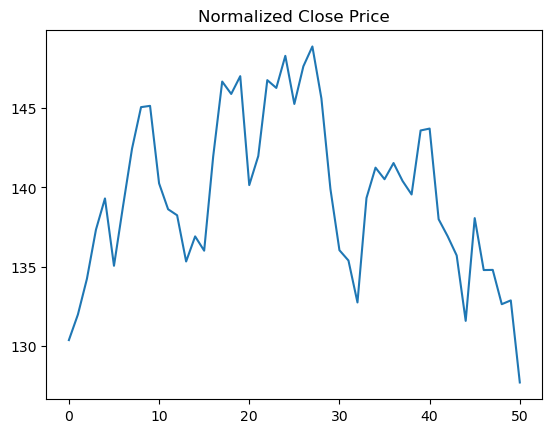

In [206]:
#define z-score for partial autocorrelation analysis
#https://en.wikipedia.org/wiki/Standard_score

z_score=3 #equal to 3-sigma i.e. ~99% of the data
len_segment=len(stock_prices) #length of the segment for analysis
#https://en.wikipedia.org/wiki/Partial_autocorrelation_function
reference=z_score/np.sqrt(len_segment)

print(len_segment)
nlag=16 #number of lags for partial autocorrelation analysis
y = stock_prices.values

segment=y[0:int(0.8*len_segment)]
test_segment = y[int(0.8*len_segment):]

y=y-np.mean(y)          #standardixe close price, zero mean, min-max -1...1
y=y/np.abs(np.max(y))

plt.plot(segment)
plt.title('Normalized Close Price')
plt.show()

Let us define the ARIMA(p, d, q) parameters

*** Look at the biggest index (lag) from partial autocorrelation (pacf) image that is still larger than reference value
Select the p = order (lag) reference value +1 ***
q can be estimated similarly by looking at the ACF plot instead of the PACF plot.
Looking at the number of lags crossing the threshold, we can determine how much of the past
would be significant enough to consider for the future.
The ones with high correlation contribute more and would be enough to predict future values


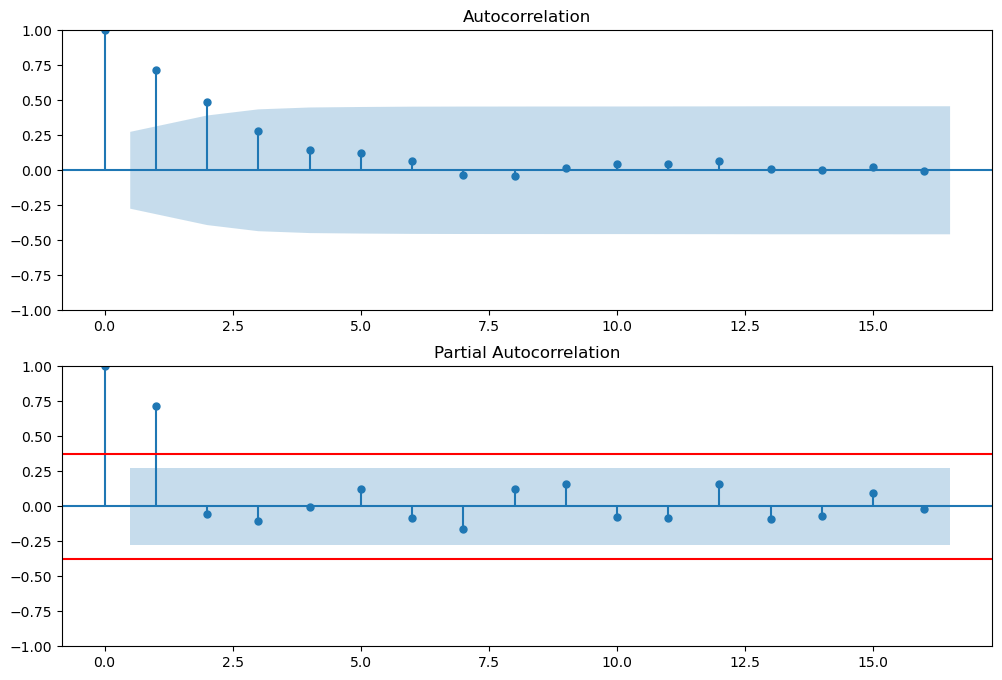

In [207]:


#show autocorrelation and partial autocorrelation of the segment
#Look at the place of first change of sign in the images
print("Let us define the ARIMA(p, d, q) parameters")

print("\n*** Look at the biggest index (lag) from partial autocorrelation (pacf) image that is still larger than reference value")
print("Select the p = order (lag) reference value +1 ***")

print("q can be estimated similarly by looking at the ACF plot instead of the PACF plot.")
print("Looking at the number of lags crossing the threshold, we can determine how much of the past")
print("would be significant enough to consider for the future.")
print("The ones with high correlation contribute more and would be enough to predict future values")

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(segment.squeeze(), lags=nlag, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(segment, lags=nlag, ax=ax2)
ax2.axhline(y=reference, color='r')
ax2.axhline(y=-reference, color='r')
plt.show()

Select p = lag +1 which would be 3 by analyzing PACF. Thus, q = 3 since there are two dots above blue threshold. 

Select p, q = 3 for arima model and d = 1 since 1st order diff p-value is below 0.05 limit.

In [208]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
print("\nLet us find the d (differencing) value, the first one that goes below 0.05 limit:")
result = adfuller(segment)
print('p-value (0.05): ', result[1])
result = adfuller(np.diff(segment))
print('1st order diff p-value (0.05): ', result[1])
result = adfuller(np.diff(np.diff(segment)))
print('2nd order diff p-value (0.05): ', result[1])
result = adfuller(np.diff(np.diff(np.diff(segment))))
print('3rd order diff p-value (0.05): ', result[1])
 
arma_model=ARIMA(segment,order=(5,1,5)).fit()
print("\n\nModel summary")
print(arma_model.summary()) 

print(arma_model.params)
print("\nPrint AIC, BIC, HQIC values for full autocorrelation")
print(arma_model.aic, arma_model.bic, arma_model.hqic)



Let us find the d (differencing) value, the first one that goes below 0.05 limit:
p-value (0.05):  0.22135440682558966
1st order diff p-value (0.05):  5.6162327595840084e-09
2nd order diff p-value (0.05):  0.00015386706471009958
3rd order diff p-value (0.05):  6.348331118506215e-06


Model summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   51
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -123.554
Date:                Fri, 20 Dec 2024   AIC                            269.108
Time:                        14:29:20   BIC                            290.140
Sample:                             0   HQIC                           277.117
                                 - 51                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025  


Print residual values
0.9973192296903002


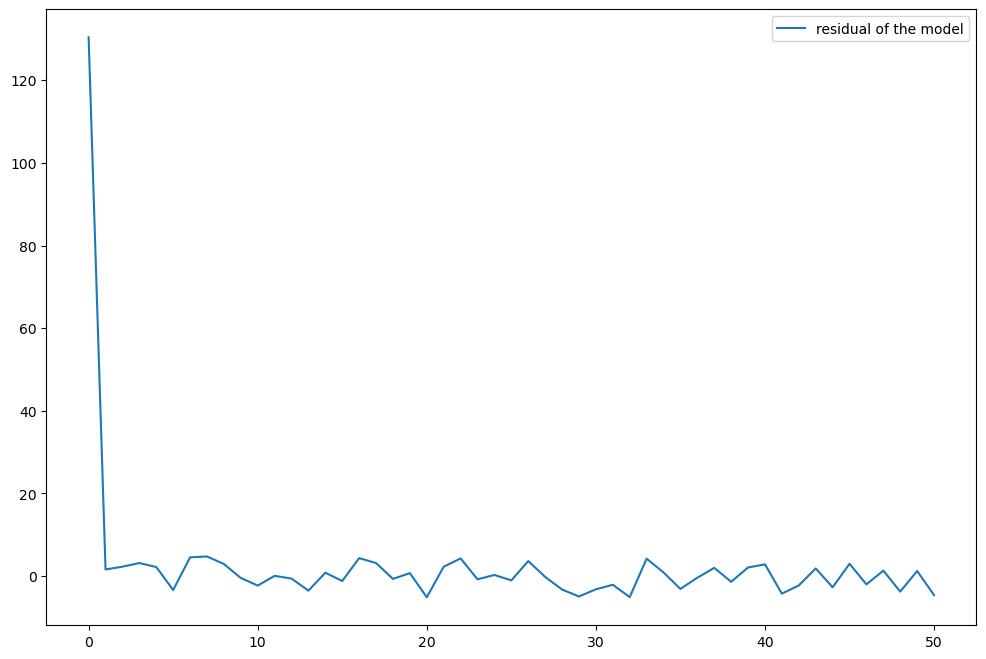


Residual normalization test for both
Full
NormaltestResult(statistic=111.56009713755157, pvalue=5.957070039415146e-25)


In [209]:
#print residual values, we can estimate the qoodness of the fit by analyzing the residuals
#The closer to 0 the statistic, the more evidence for positive serial correlation. 
#The closer to 4, the more evidence for negative serial correlation.
#https://www.statsmodels.org/stable/generated/statsmodels.stats.stattools.durbin_watson.html
print("\nPrint residual values")
print(sm.stats.durbin_watson(arma_model.resid))

fig = plt.figure(figsize=(12, 8))
plt.plot(arma_model.resid,label='residual of the model')
plt.legend()
plt.show()

print("\nResidual normalization test for both")
print("Full")
print(stats.normaltest(arma_model.resid))


Residual value indicates positive autocorrelation and plot indicates that model performance is good since residual values appear near 0.



DataFrame
            AC         Q  Prob(>Q)
lag                               
1.0   0.011838  0.007576  0.930639
2.0   0.016929  0.023385  0.988376
3.0   0.022346  0.051504  0.996939
4.0   0.015513  0.065344  0.999478
5.0  -0.026245  0.105819  0.999813
6.0   0.033265  0.172287  0.999900
7.0   0.033841  0.242640  0.999951
8.0   0.018727  0.264684  0.999988
9.0  -0.004178  0.265808  0.999998
10.0 -0.017750  0.286578  1.000000
11.0 -0.004808  0.288140  1.000000
12.0 -0.006195  0.290800  1.000000
13.0 -0.033687  0.371522  1.000000
14.0  0.002379  0.371936  1.000000
15.0 -0.010807  0.380704  1.000000
16.0  0.028644  0.444068  1.000000
17.0  0.018270  0.470606  1.000000


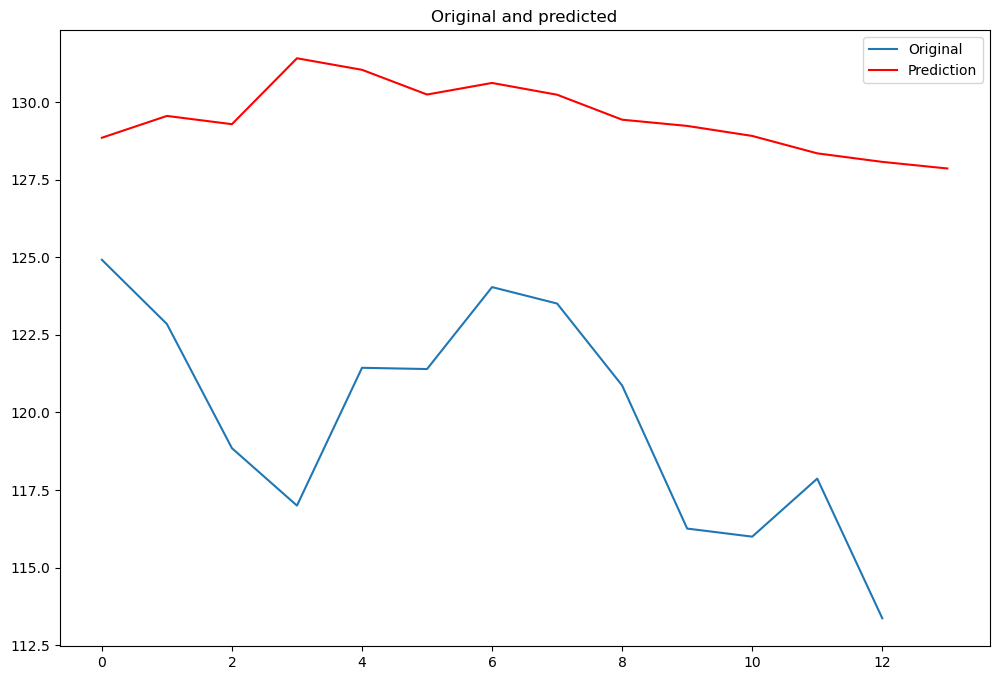

In [210]:
#Organize data to neat datatable format
r, q, p = sm.tsa.acf(arma_model.resid.squeeze(), fft=True, qstat=True)

# Ensure all arrays have the same length
min_length = min(len(r[1:]), len(q), len(p))
r = r[1:min_length+1]
q = q[:min_length]
p = p[:min_length]

data = np.c_[np.arange(1, min_length+1), r, q, p]

table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])
print("\nDataFrame")
print(table.set_index("lag"))

#finally, predictions from model

predict_prices = arma_model.predict(start=len(segment), end=len(stock_prices), dynamic=True) 
fig = plt.figure(figsize=(12, 8))
plt.plot(test_segment,label='Original')
plt.plot(predict_prices,'r', label='Prediction')
plt.title("Original and predicted")
plt.legend()
plt.show()

By trying different parameters, the results wont come better than this. ARIMA model is not able to predict the bearish trend for the stock. Further optimization, would require more data or different features. Also different approach to model could be tested, since there are differently constructed implementations and tutorials on web.

### Task 2

**Copy the ‘ARIMA_example.py’ code, tidy it up (remove unnecessary parts) and import
the pickle file: “Nepal_electricity_consumption_in_MWh.pkl” from 4th folder. The
seasonality is very clear in this data.**

Import pickle file

In [268]:
# Load pickle file
import pickle

# Load pickle file, contains dataset
with open('Nepal_electricity_consumption_in_MWh.pkl', 'rb') as f:
    data = pickle.load(f)

# Load the data
print(len(data))
data.head(100)

8712


,Date,Load
23,2016-04-13 00:00:00,682.14
0,2016-04-13 01:00:00,717.49
1,2016-04-13 02:00:00,707.64
2,2016-04-13 03:00:00,706.44
3,2016-04-13 04:00:00,737.34
...,...,...
94,2016-04-16 23:00:00,771.89
119,2016-04-17 00:00:00,764.24
96,2016-04-17 01:00:00,722.89
97,2016-04-17 02:00:00,596.24


Preprocess data

In [269]:
# sort by date
data = data.sort_values('Date')

# convert date to datetime
data['Date'] = pd.to_datetime(data['Date'])

# see missing values
data.isnull().sum()

# fill missing values with the previous value
data = data.fillna(method='ffill')


Plot data

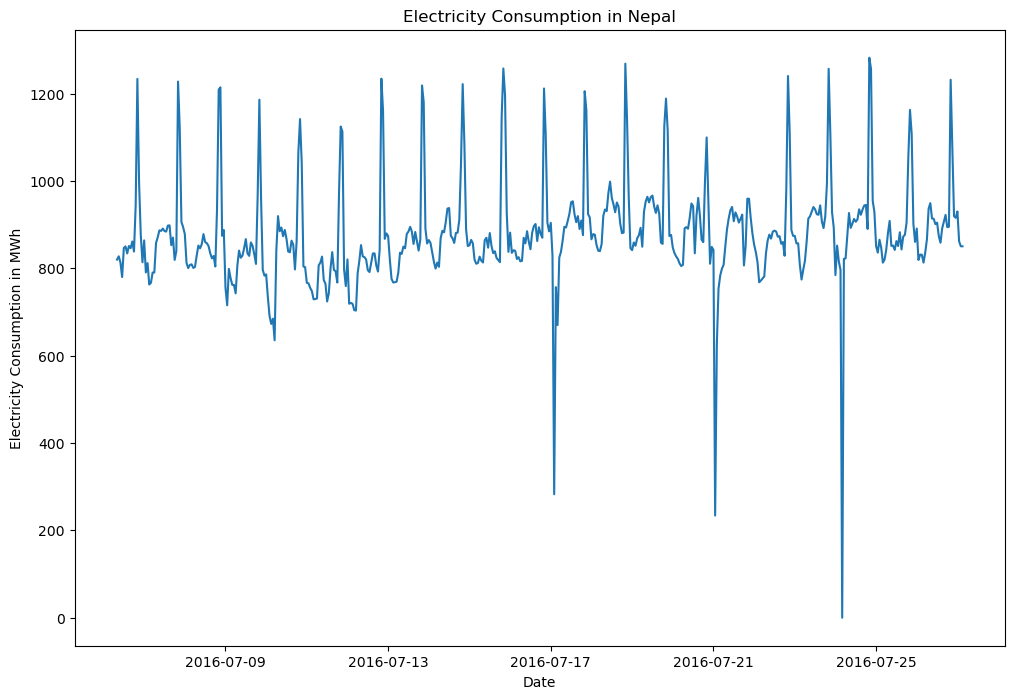

In [270]:
# plot the data
date = data['Date']
X = data['Load']

plt.figure(figsize=(12, 8))
plt.plot(date[2000:2500], X[2000:2500])
plt.xlabel('Date')
plt.ylabel('Electricity Consumption in MWh')
plt.title('Electricity Consumption in Nepal')
plt.show()

Take closer look to peaks

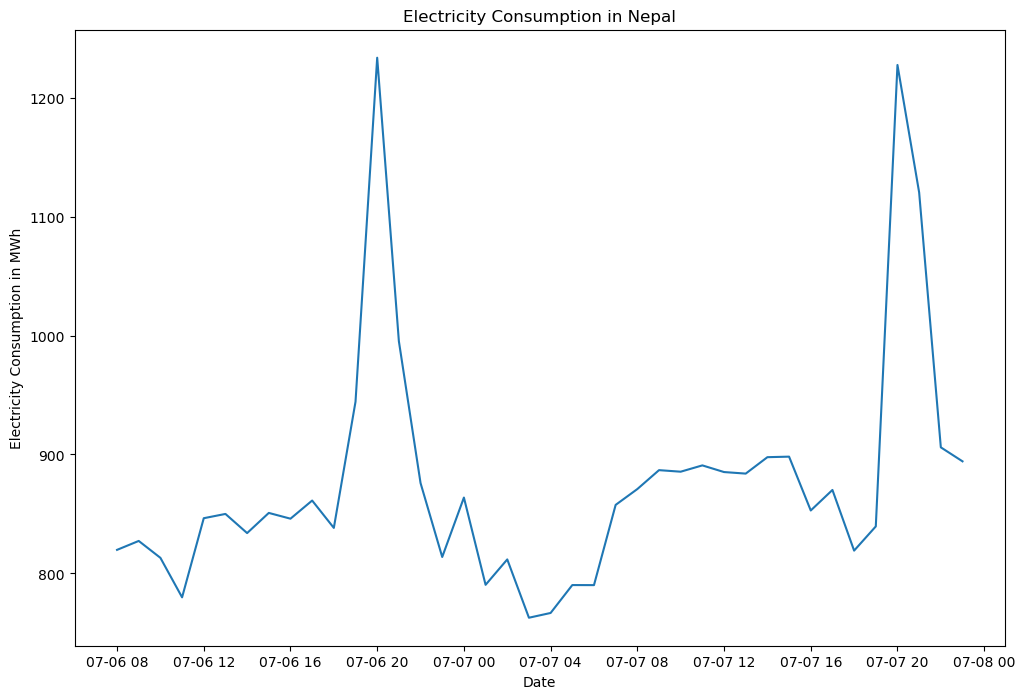

In [271]:
plt.figure(figsize=(12, 8))
plt.plot(date[2000:2040], X[2000:2040])
plt.xlabel('Date')
plt.ylabel('Electricity Consumption in MWh')
plt.title('Electricity Consumption in Nepal')
plt.show()

Data appears to have high peaks during evening, approximately during hours 20-22. Use 30 as number of lags to capture daily patterns

8712
6969 1743


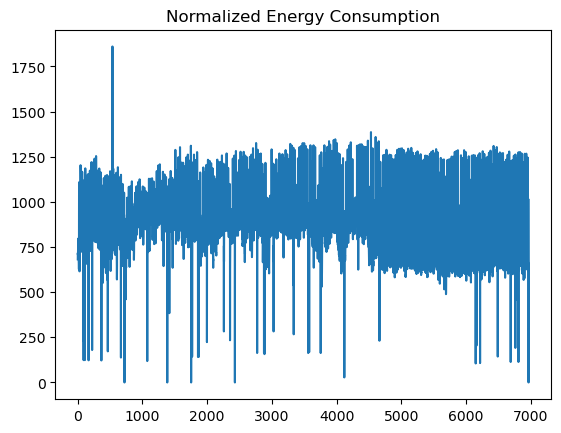

In [276]:
z_score=3 #equal to 3-sigma i.e. ~99% of the data
len_segment=len(data) #length of the segment for analysis
#https://en.wikipedia.org/wiki/Partial_autocorrelation_function
reference=z_score/np.sqrt(len_segment)

print(len_segment)
nlag= 48 #number of lags for partial autocorrelation analysis
y = data['Load'].values

segment=y[0:int(0.8*len_segment)]
test_segment = y[int(0.8*len_segment):]

print(len(segment), len(test_segment))
y=y-np.mean(y)          #standardixe close price, zero mean, min-max -1...1
y=y/np.abs(np.max(y))

plt.plot(segment)
plt.title('Normalized Energy Consumption')
plt.show()

Define parameters for ARIMA model

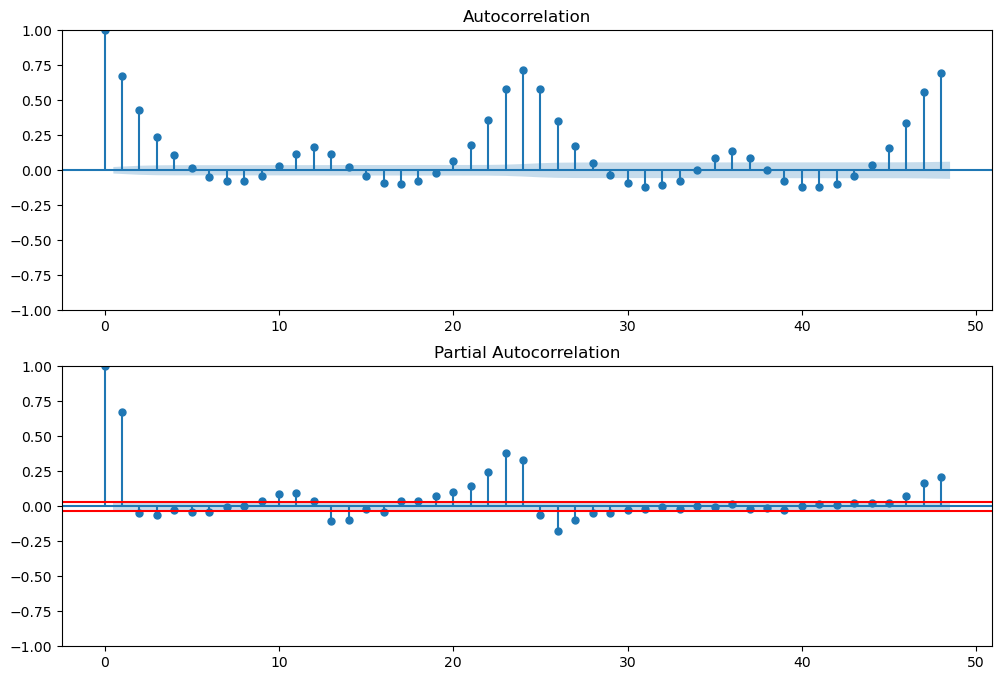

In [277]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(segment.squeeze(), lags=nlag, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(segment, lags=nlag, ax=ax2)
ax2.axhline(y=reference, color='r')
ax2.axhline(y=-reference, color='r')
plt.show()

nlag=30 analysis: Select 28 as order of p and q, since it is the last statistically significant order in the plots. It keeps two peaks inside.

nlag = 48 analysis: Select, 48 as order of p and q. It holds three peaks inside and should increase prediction for longer seasonal trends.

p-value seems to be below the 0.05 limit, select p = 0.

In [278]:
print("\nLet us find the d (differencing) value, the first one that goes below 0.05 limit:")
result = adfuller(segment)
print('p-value (0.05): ', result[1])
result = adfuller(np.diff(segment))
print('1st order diff p-value (0.05): ', result[1])
result = adfuller(np.diff(np.diff(segment)))
print('2nd order diff p-value (0.05): ', result[1])
result = adfuller(np.diff(np.diff(np.diff(segment))))
print('3rd order diff p-value (0.05): ', result[1])


Let us find the d (differencing) value, the first one that goes below 0.05 limit:
p-value (0.05):  1.045837912904957e-10
1st order diff p-value (0.05):  0.0
2nd order diff p-value (0.05):  0.0
3rd order diff p-value (0.05):  0.0


Initialize ARIMA model

In [279]:
arma_model=ARIMA(segment,order=(48,0,48)).fit()
print("\n\nModel summary")
print(arma_model.summary()) 

print(arma_model.params)
print("\nPrint AIC, BIC, HQIC values for full autocorrelation")
print(arma_model.aic, arma_model.bic, arma_model.hqic)



Model summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6969
Model:               ARIMA(48, 0, 48)   Log Likelihood              -40696.220
Date:                Fri, 20 Dec 2024   AIC                          81588.439
Time:                        15:00:11   BIC                          82259.663
Sample:                             0   HQIC                         81819.784
                               - 6969                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        861.9449    624.397      1.380      0.167    -361.851    2085.741
ar.L1         -0.3514      0.188     -1.865      0.062      -0.721       0.018
ar.L2          0.0101      0.177    

Show residual values


Print residual values
1.9022854622464798


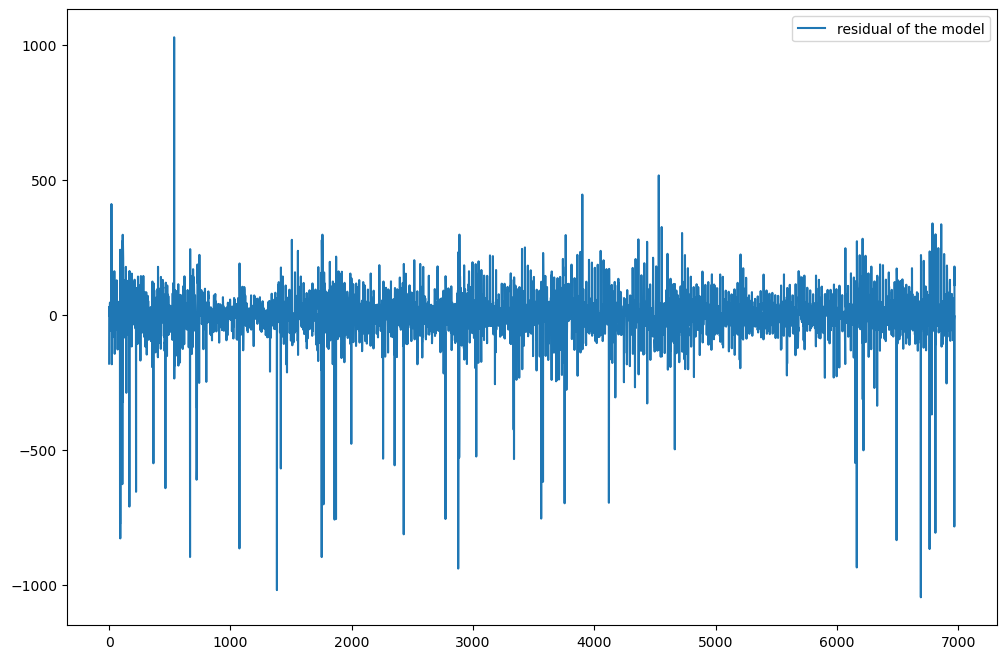


Residual normalization test for both
Full
NormaltestResult(statistic=5964.1018811476815, pvalue=0.0)


In [280]:
print("\nPrint residual values")
print(sm.stats.durbin_watson(arma_model.resid))

fig = plt.figure(figsize=(12, 8))
plt.plot(arma_model.resid,label='residual of the model')
plt.legend()
plt.show()

print("\nResidual normalization test for both")
print("Full")
print(stats.normaltest(arma_model.resid))

Residual values for both nlag = 30 and 48 are quite the same, majority of values remains near zero excluding trend peaks.

Make predictions

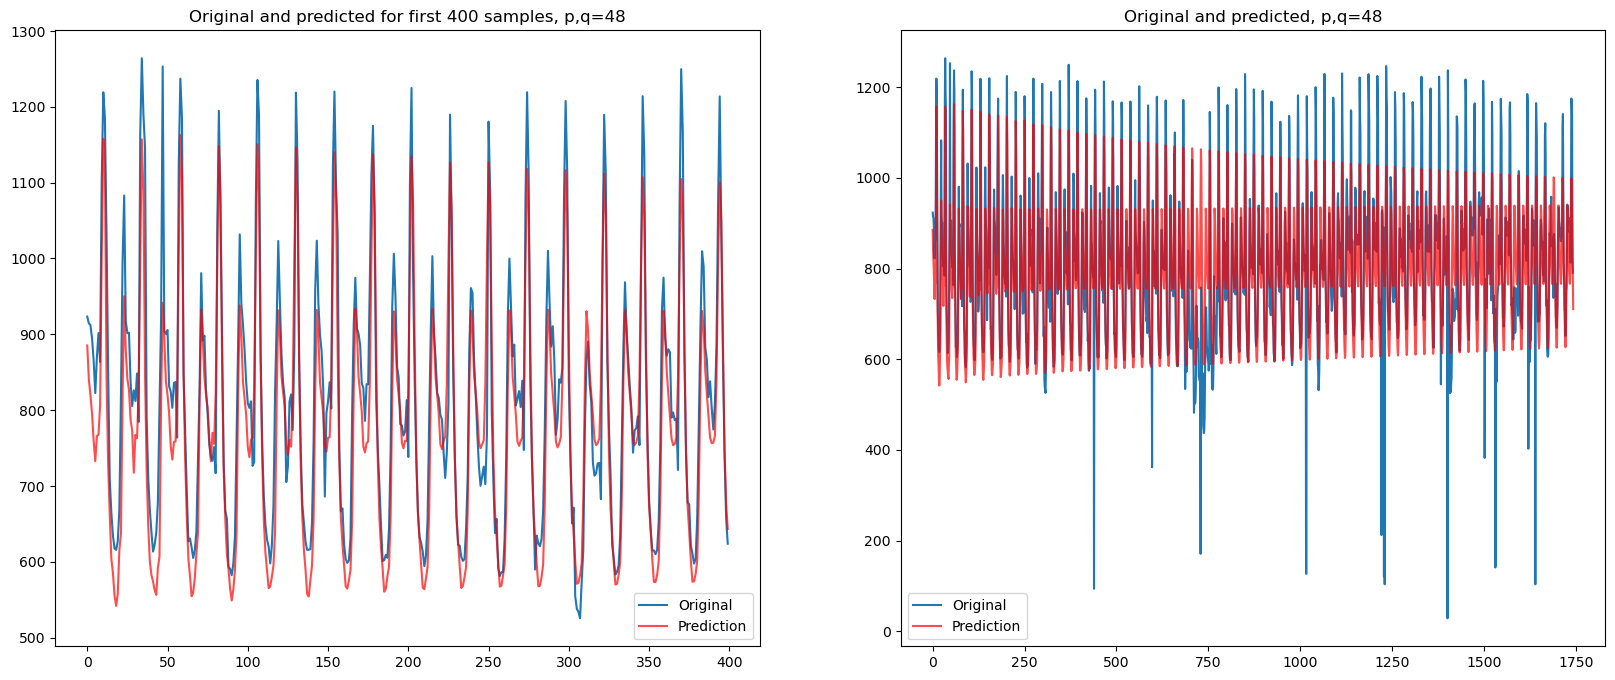

In [291]:
#Organize data to neat datatable format
r, q, p = sm.tsa.acf(arma_model.resid.squeeze(), fft=True, qstat=True)

# Ensure all arrays have the same length
min_length = min(len(r[1:]), len(q), len(p))
r = r[1:min_length+1]
q = q[:min_length]
p = p[:min_length]

data = np.c_[np.arange(1, min_length+1), r, q, p]

table = pd.DataFrame(data, columns=["lag", "AC", "Q", "Prob(>Q)"])

#finally, predictions from model

predict_prices = arma_model.predict(start=len(segment), end=len(y), dynamic=True) 

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(test_segment[:400], label='Original')
ax[0].plot(predict_prices[:400], 'r', label='Prediction', alpha=0.7)
ax[0].set_title("Original and predicted for first 400 samples, p,q=48")
ax[0].legend()

ax[1].plot(test_segment, label='Original')
ax[1].plot(predict_prices, 'r', label='Prediction', alpha=0.7)
ax[1].set_title("Original and predicted, p,q=48")
ax[1].legend()
plt.show()

It seems that increased value for p and q have made the model work better and now it recognizes higher peaks between smaller peaks. However, looking at the total predicted, the peaks have decreasing trend and downside peaks tends to drop slightly under the orignal. It seems that prediction window may be too large and model could work well predicting small window into.

Prediction using p, q = 28:

ARIMA is able to recognize smaller peaks well but predictions for peaks are in the same level. Model fails to predict consumption drops. Another test is made after this with increased lag window and p and q values of ARIMA.

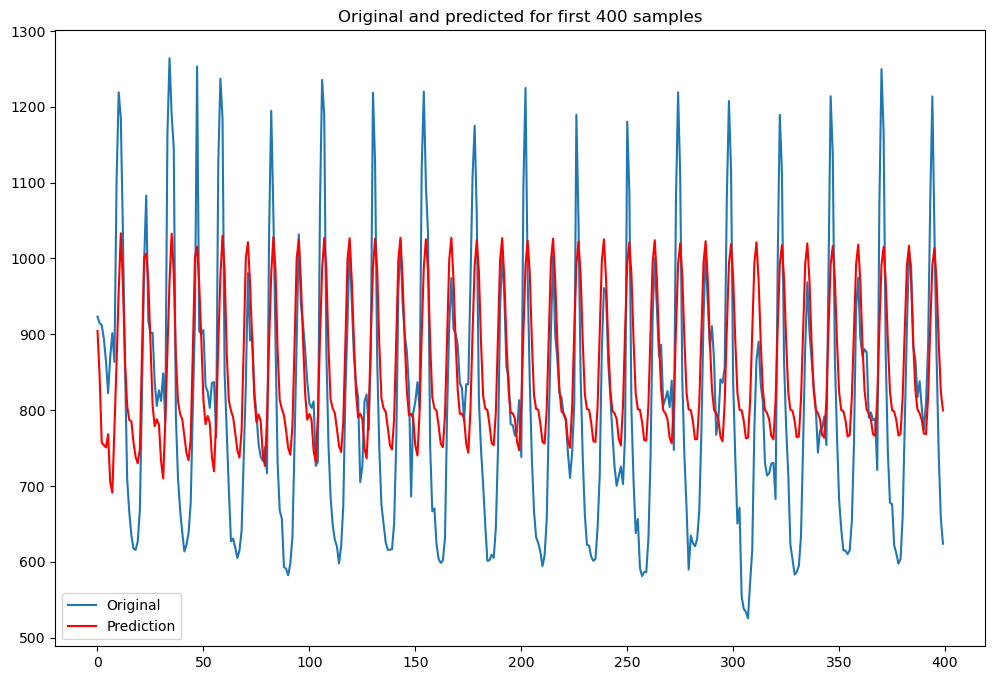